In [17]:
import numpy as np
import matplotlib.pyplot as plt

import pmsimulator as pms

Decisions that I made:
* Periodic BCs. This is not a user choice.
* Simulation grid is a square
* Can have multiple species of particles (perhaps want to keep track of different populations, etc)
* There is a single Simulator object which stores the grid as well as the particles associated with the simulation.
* Right now, solving Poisson eq: $\phi(k) = \rho(k)/k^2$

# Testing

In [18]:
# Create a PMSimulator object based on current simulation parameters
simulator = pms.PMSimulator(domain_size=1.0, grid_size=0.02)

# Create 2 species of particles
simulator.create_particles(5000, species_name='background_particles')
simulator.create_particles(100, species_name='overdensity_particles')

In [19]:
# Store in variables for easy access

parts1, parts2 = (simulator.background_particles, simulator.overdensity_particles)
# parts1 = simulator.species_list[0]

In [20]:
# Initialize attributes of the particle species
parts1.x_positions.initialize(distribution='uniform', bounds=(0,1))
parts1.y_positions.initialize(distribution='uniform', bounds=(0,1))
parts1.masses.initialize(distribution='allones')
parts1.apply_periodic_bc()

parts2.x_positions.initialize(distribution='normal', mean=0.5, std=0.05)
parts2.y_positions.initialize(distribution='normal', mean=0.5, std=0.05)
parts2.masses.initialize(distribution='allones')
parts2.apply_periodic_bc()

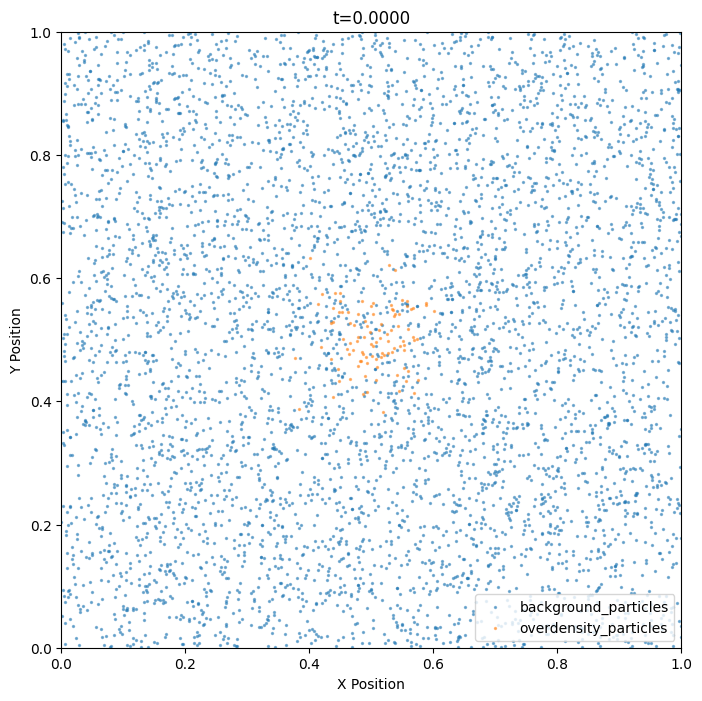

In [21]:
simulator.plot_snapshot()

In [22]:
simulator.advance(30.0, adaptive_time=False, animate=True, temp_path='/Volumes/Yarones_SSD/temp', 
                  save_path='/Users/yaronetokayer/Desktop/test.mov')

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --

In [ ]:
simulator.reset

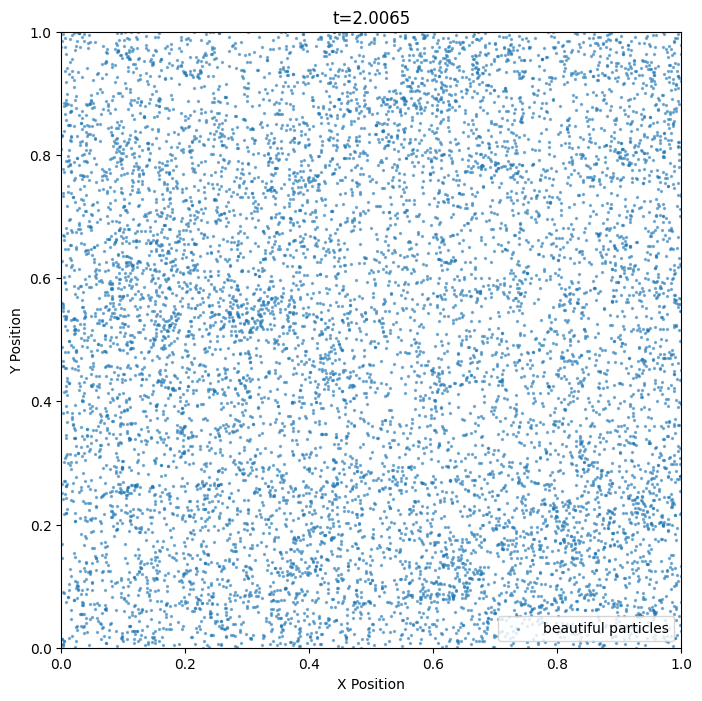

In [16]:
simulator.advance(1.0, adaptive_time=True)
simulator.plot_snapshot()

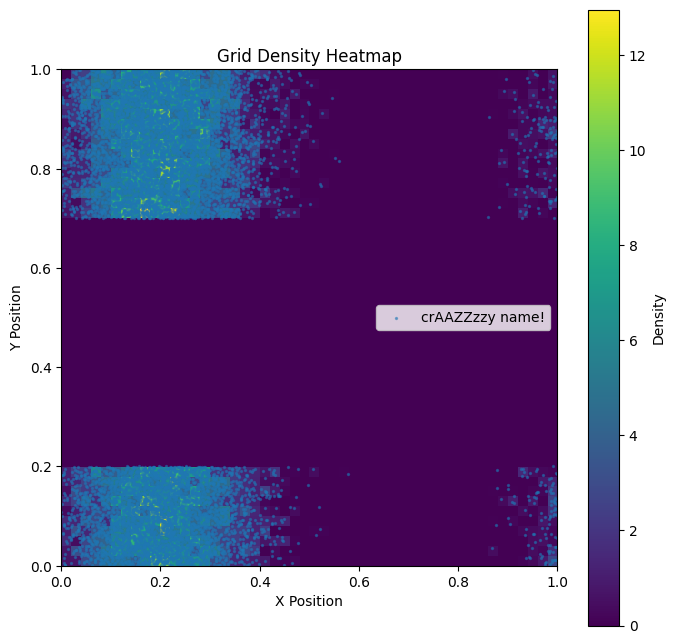

In [9]:
simulator.grid.assign_density(parts1)
simulator.grid.plot_density_heatmap(particles=parts1)

In [9]:
simulator.particles_1.calculate_accels(simulator.grid, method='ngp')

In [10]:
simulator.particles_1.update(0.1)

In [11]:
simulator.grid.assign_density(parts1)
simulator.grid.compute_potential()
simulator.particles_1.calculate_accels(simulator.grid, method='ngp')
simulator.particles_1.update(0.1)

In [12]:
simulator.grid.assign_density(parts1)
simulator.grid.compute_potential()
simulator.particles_1.calculate_accels(simulator.grid, method='ngp')
simulator.particles_1.update(0.1)

In [13]:
simulator.grid.assign_density(parts1)
simulator.grid.compute_potential()
simulator.particles_1.calculate_accels(simulator.grid, method='ngp')
simulator.particles_1.update(0.1)

In [14]:
simulator.grid.assign_density(parts1)
simulator.grid.compute_potential()
simulator.particles_1.calculate_accels(simulator.grid, method='ngp')

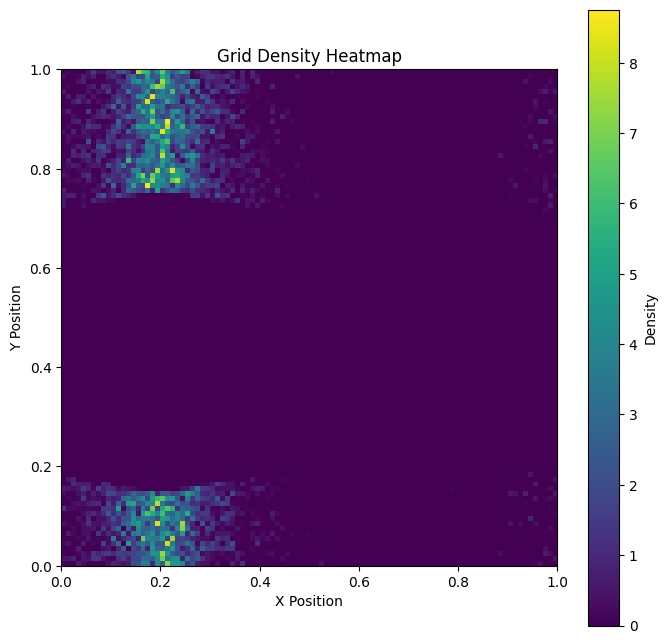

In [15]:
simulator.grid.plot_density_heatmap()

In [16]:
parts1.x_velocities.data

array([-0.01105309, -0.23547173,  0.18835068, ..., -0.01216888,
       -0.24272919,  0.05608559])

To-do:
* add `cic` and `ngp` methods for density calculation
* add `cic` and `tsc` methods for acceleration calculation
* solve potential energy issue for energy conservation
* make `advance()` function in the `simulator` class
* work on a visualization for the `simulator` class
* Add `nfw` option for initializing

In [33]:
for i in range(2):
    print(i)

0
1


In [11]:
np.max([0.5, 4, 0])

4.0

In [12]:
not 3

False